In [10]:
import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn as sns
import pandas as pd

# Old

In [3]:
# Load gradients for one modality (from the previous case)
file_path = f"/data/wang/junh/results/Fuse_moe/all_ihm/TS_Text_gradients_8.json"
with open(file_path, 'r') as f:
    one_modality_gradients = {k: np.array(v) for k, v in json.load(f).items()}

In [4]:
# Load gradients for one modality (from the previous case)
file_path = f"/data/wang/junh/results/Fuse_moe/all_ihm/TS_Text_logits_8.json"
with open(file_path, 'r') as f:
    one_modality_logits = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/data/wang/junh/results/Fuse_moe/all_ihm/TS_Text_logits_8.json'

In [ ]:
embedding = pd.read_csv('/data/wang/junh/results/Fuse_moe/all_ihm/TS_Text_test_continuous.csv')

In [ ]:
len(one_modality_logits)

228

In [ ]:
one_modality_gradients.get('trans_self_cross_ts_txt.layers.0.moe.w_gate.0').shape
# 6144 = 3*16*128

(6144, 16)

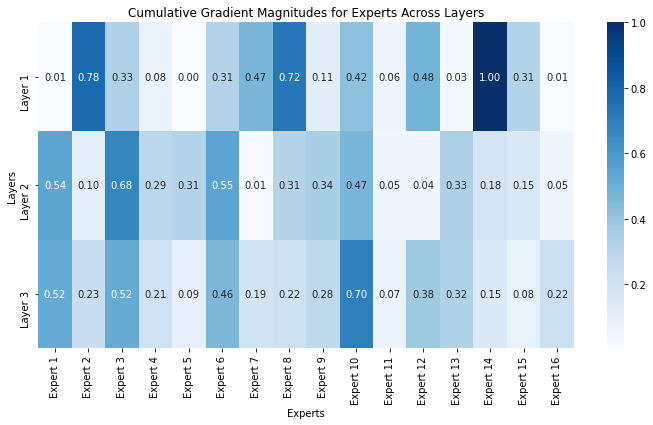

In [ ]:
# Initialize the data structure for the heatmap
expert_gradients = np.zeros((3, 16))  # 3 layers (rows) x 16 experts (columns)

for name, gradient in one_modality_gradients.items():
    if "layers.0" in name:
        expert_gradients[0, :] += np.mean(np.abs(gradient), axis=0)  # Layer 1
    elif "layers.1" in name:
        expert_gradients[1, :] += np.mean(np.abs(gradient), axis=0)  # Layer 2
    elif "layers.2" in name:
        expert_gradients[2, :] += np.mean(np.abs(gradient), axis=0)  # Layer 3

# Normalize the gradients (optional, for better visualization)
expert_gradients /= expert_gradients.max()

# Create the heatmap
plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(expert_gradients, annot=True, fmt=".2f", cmap="Blues", cbar=True,
            xticklabels=[f"Expert {i+1}" for i in range(16)],
            yticklabels=["Layer 1", "Layer 2", "Layer 3"])

plt.xlabel("Experts")
plt.ylabel("Layers")
plt.title("Cumulative Gradient Magnitudes for Experts Across Layers")
plt.show()

# TS_Missing

In [ ]:
# Load gradients for one modality (from the previous case)
one_modality_gradients = {}
for epoch in range(1, 9):
    file_path = f"/data/wang/junh/githubs/Multimodal-Transformer/w_gate_analysis/TS_Missing/TS_{epoch}.json"
    with open(file_path, 'r') as f:
        one_modality_gradients[epoch] = {k: np.array(v) for k, v in json.load(f).items()}

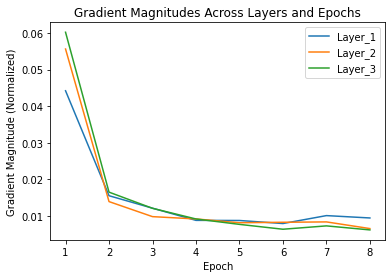

In [ ]:
# Prepare data for visualization
epochs = list(range(1, 9))
layer_norms = {f"Layer_{i+1}": [] for i in range(3)}  # Assuming 3 layers

for epoch in epochs:
    for name, gradient in one_modality_gradients[epoch].items():
        if "layers.0" in name:
            layer_norms["Layer_1"].append(np.linalg.norm(gradient))  # Frobenius norm
        elif "layers.1" in name:
            layer_norms["Layer_2"].append(np.linalg.norm(gradient))
        elif "layers.2" in name:
            layer_norms["Layer_3"].append(np.linalg.norm(gradient))

# Plot gradient magnitudes for each layer
for layer, norms in layer_norms.items():
    plt.plot(epochs, norms, label=layer)

plt.xlabel("Epoch")
plt.ylabel("Gradient Magnitude (Normalized)")
plt.title("Gradient Magnitudes Across Layers and Epochs")
plt.legend()
plt.show()


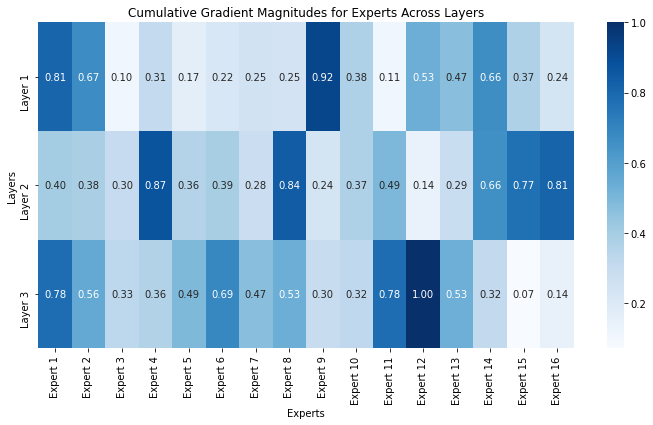

In [ ]:
# Initialize the data structure for the heatmap
expert_gradients = np.zeros((3, 16))  # 3 layers (rows) x 16 experts (columns)

# Aggregate gradients for each layer and expert
for epoch in range(1, 9):  # Assuming 8 epochs
    for name, gradient in one_modality_gradients[epoch].items():
        if "layers.0" in name:
            expert_gradients[0, :] += np.mean(np.abs(gradient), axis=0)  # Layer 1
        elif "layers.1" in name:
            expert_gradients[1, :] += np.mean(np.abs(gradient), axis=0)  # Layer 2
        elif "layers.2" in name:
            expert_gradients[2, :] += np.mean(np.abs(gradient), axis=0)  # Layer 3

# Normalize the gradients (optional, for better visualization)
expert_gradients /= expert_gradients.max()

# Create the heatmap
plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(expert_gradients, annot=True, fmt=".2f", cmap="Blues", cbar=True,
            xticklabels=[f"Expert {i+1}" for i in range(16)],
            yticklabels=["Layer 1", "Layer 2", "Layer 3"])

plt.xlabel("Experts")
plt.ylabel("Layers")
plt.title("Cumulative Gradient Magnitudes for Experts Across Layers")
plt.show()

In [ ]:
# Access the data from the heatmap
expert_gradients

array([[0.81103677, 0.66935425, 0.10428309, 0.31053981, 0.16745677,
        0.21701583, 0.24950749, 0.24507787, 0.92128441, 0.37519655,
        0.1051626 , 0.53409812, 0.4692349 , 0.66340021, 0.37016015,
        0.23843514],
       [0.40436167, 0.38357713, 0.30368709, 0.8707408 , 0.35665903,
        0.39090462, 0.28005719, 0.84292466, 0.23956814, 0.37464913,
        0.49472443, 0.13698886, 0.29177544, 0.65861704, 0.7699238 ,
        0.81390745],
       [0.778846  , 0.55643349, 0.3320291 , 0.36479772, 0.48867598,
        0.69017398, 0.46868349, 0.53429217, 0.29756642, 0.32275302,
        0.78024714, 1.        , 0.53021767, 0.31517545, 0.07142044,
        0.14060199]])

# Two Modalities

In [11]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_gradients(base_path, file_name, num_epochs=8):
    """Load gradient data from JSON files for multiple epochs.

    Args:
    base_path (str): The directory path where the files are stored.
    file_name (str): The base name of the files without the epoch number.
    num_epochs (int): The number of epochs to load data for.

    Returns:
    dict: A dictionary containing gradient data for each epoch.
    """
    gradients = {}
    for epoch in range(1, num_epochs + 1):
        file_path = f"{base_path}/{file_name}_gradients_{epoch}.json"
        with open(file_path, 'r') as f:
            gradients[epoch] = {k: np.array(v) for k, v in json.load(f).items()}
    return gradients


def calculate_expert_averages(gradients, modality, layer):
    expert_averages = []
    for epoch in range(1, 9):  # Assuming there are 8 epochs
        for name, grad in gradients[epoch].items():
            if modality in name and f"layers.{layer}" in name:
                avg_grad = np.mean(np.abs(grad), axis=0)  # Average over tokens
                expert_averages.append(avg_grad)
    return np.array(expert_averages)  # Shape: (epochs, experts)

def aggregate_gradients(gradients, modalities, num_layers, num_experts):
    expert_gradients = [np.zeros((num_layers, num_experts)) for _ in modalities]
    for i, modality in enumerate(modalities):
        for epoch in range(1, 9):
            for name, gradient in gradients[epoch].items():
                for layer in range(num_layers):
                    if modality in name and f"layers.{layer}" in name:
                        expert_gradients[i][layer, :] += np.mean(np.abs(gradient), axis=0)
        expert_gradients[i] /= expert_gradients[i].max()  # Normalize
    return expert_gradients



In [12]:
def plot_expert_averages(gradient_data, modalities, modality_labels, num_layers=3):
    fig, axes = plt.subplots(1, num_layers, figsize=(18, 6), sharey=True)
    fig.suptitle('Expert Gradients for Two Modalities Across Layers')

    for i in range(num_layers):
        for j, modality in enumerate(modalities):
            modality_experts = calculate_expert_averages(gradient_data, modality, i)
            axes[i].plot(range(1, 9), np.mean(modality_experts, axis=1), label=f"{modality_labels[j]}, Layer {i}")
            axes[i].set_title(f"Layer {i + 1}")
            axes[i].set_xlabel("Epoch")
            if i == 0:
                axes[i].set_ylabel("Average Gradient Magnitude")
            axes[i].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust for overall title
    plt.show()

def plot_cumulative_gradients(expert_gradients, modality_labels):
    fig, axes = plt.subplots(1, len(modality_labels), figsize=(16, 6), sharey=True)

    for i, (grads, label) in enumerate(zip(expert_gradients, modality_labels)):
        sns.heatmap(grads, annot=True, fmt=".2f", cmap="Blues", cbar=True, ax=axes[i],
                    xticklabels=[f"Expert {j+1}" for j in range(grads.shape[1])],
                    yticklabels=[f"Layer {k+1}" for k in range(grads.shape[0])])
        axes[i].set_title(f"Cumulative Gradients for {label}")
        axes[i].set_xlabel("Experts")
        axes[i].set_ylabel("Layers")

    plt.suptitle("Cumulative Gradient Magnitudes for Experts Across Layers and Modalities")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


## LOS

In [15]:
TS_Text.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8])

In [17]:
TS_Text.get(1).keys()

dict_keys(['trans_self_cross_ts_txt.layers.0.moe.w_gate.0', 'trans_self_cross_ts_txt.layers.0.moe.w_gate.1', 'trans_self_cross_ts_txt.layers.1.moe.w_gate.0', 'trans_self_cross_ts_txt.layers.1.moe.w_gate.1', 'trans_self_cross_ts_txt.layers.2.moe.w_gate.0', 'trans_self_cross_ts_txt.layers.2.moe.w_gate.1'])

TS and Text


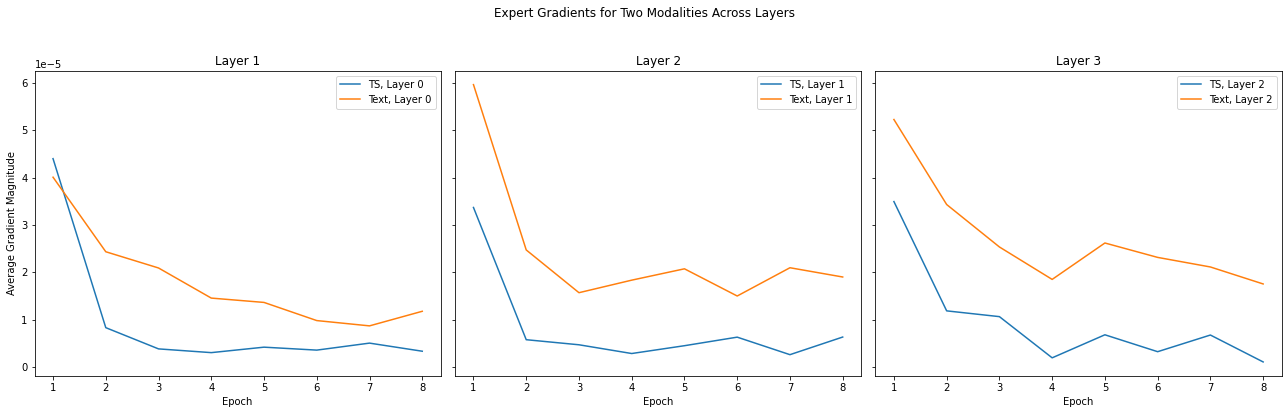

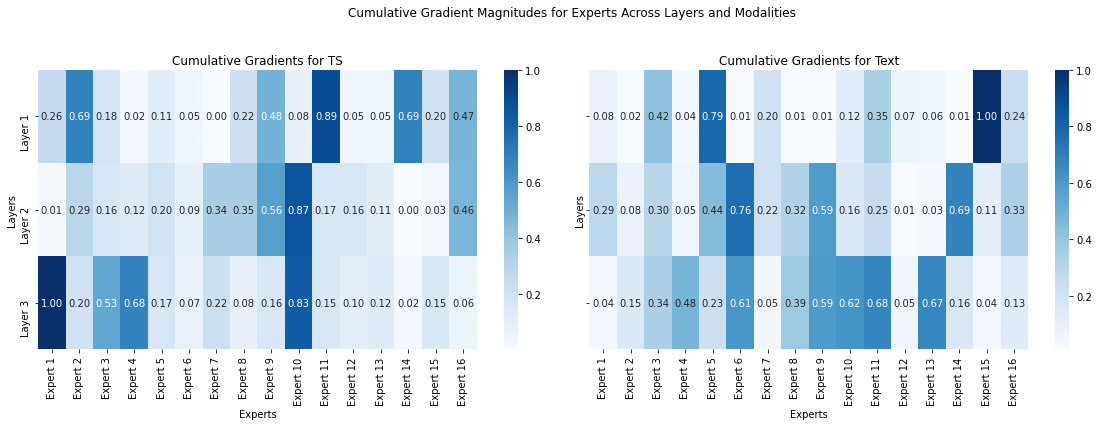

In [13]:
base_path = "/data/wang/junh/results/Fuse_moe/all_los/"
file_name = "TS_Text"

TS_Text = load_gradients(base_path, file_name)

# Define modalities and labels
modalities = ["w_gate.0", "w_gate.1"]
modality_labels = ["TS", "Text"]

# Calculate and plot expert averages
print("TS and Text")
plot_expert_averages(TS_Text, modalities, modality_labels)

# Aggregate and plot cumulative gradients
aggregated_gradients = aggregate_gradients(TS_Text, modalities, 3, 16)
plot_cumulative_gradients(aggregated_gradients, modality_labels)

- PID

Redundancy between TS and Text


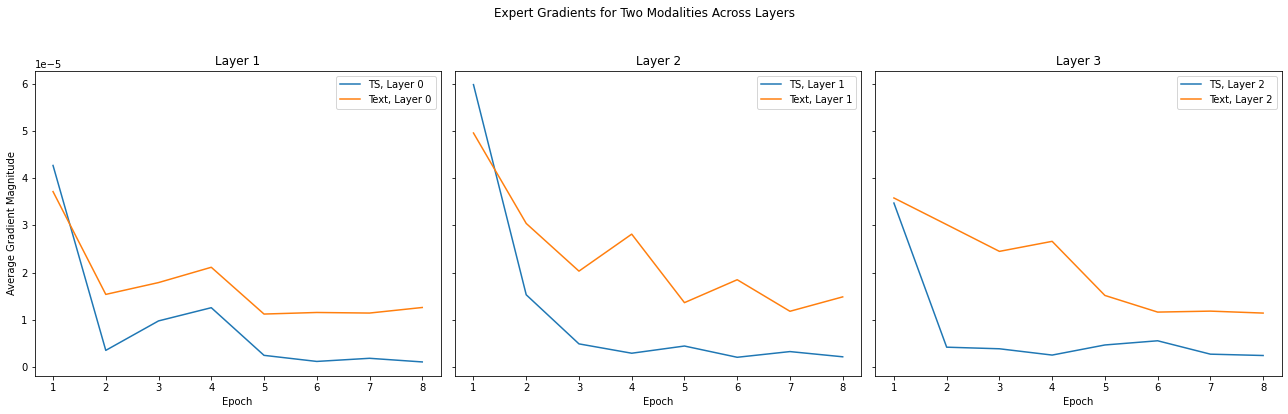

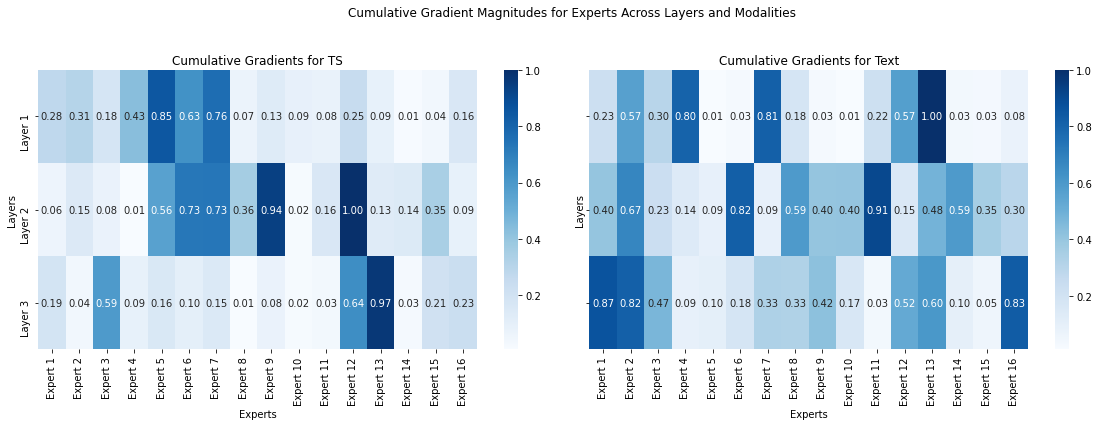

In [ ]:
base_path = "/data/wang/junh/results/Fuse_moe/all_los/pid_results_2mod/gradients"
file_name = "TS_Text/R_TS_Text"

R_TS_Text = load_gradients(base_path, file_name)

# Define modalities and labels
modalities = ["w_gate.0", "w_gate.1"]
modality_labels = ["TS", "Text"]

# Calculate and plot expert averages
print("Redundancy between TS and Text")
plot_expert_averages(R_TS_Text, modalities, modality_labels)

# Aggregate and plot cumulative gradients
aggregated_gradients = aggregate_gradients(R_TS_Text, modalities, 3, 16)
plot_cumulative_gradients(aggregated_gradients, modality_labels)

Redundancy between TS and Text


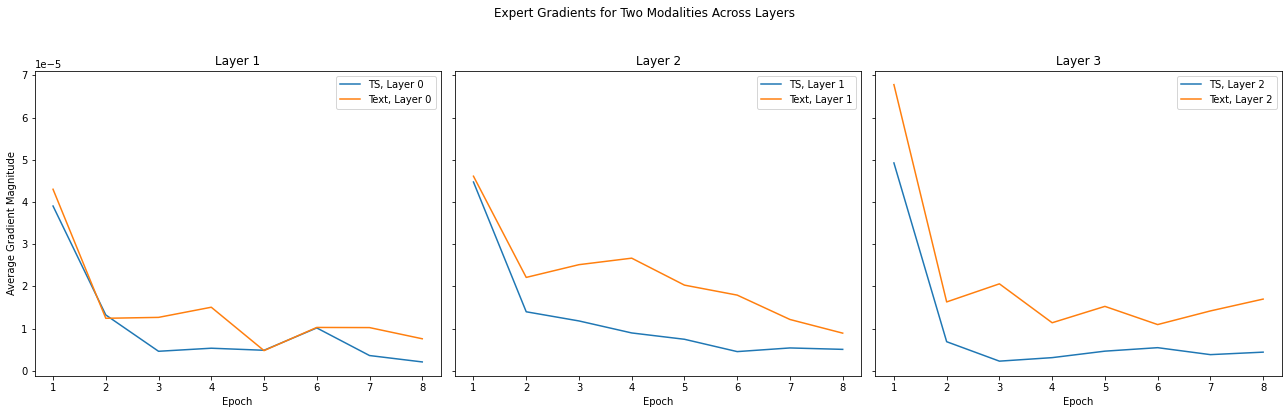

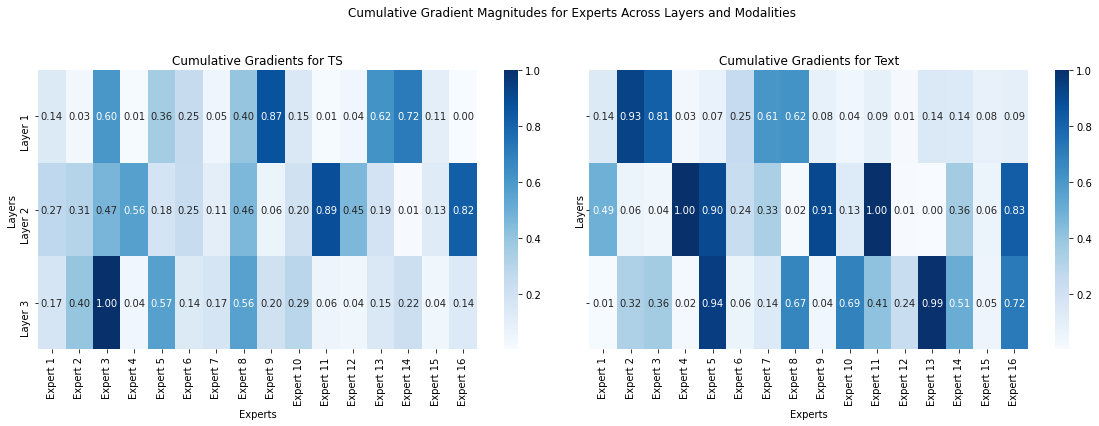

In [17]:
base_path = "/data/wang/junh/results/Fuse_moe/all_los/pid_results_2mod/gradients"
file_name = "TS_Text/U_TS_Text"

U_TS_Text = load_gradients(base_path, file_name)

# Define modalities and labels
modalities = ["w_gate.0", "w_gate.1"]
modality_labels = ["TS", "Text"]

# Calculate and plot expert averages
print("Redundancy between TS and Text")
plot_expert_averages(U_TS_Text, modalities, modality_labels)

# Aggregate and plot cumulative gradients
aggregated_gradients = aggregate_gradients(U_TS_Text, modalities, 3, 16)
plot_cumulative_gradients(aggregated_gradients, modality_labels)

Redundancy between TS and Text


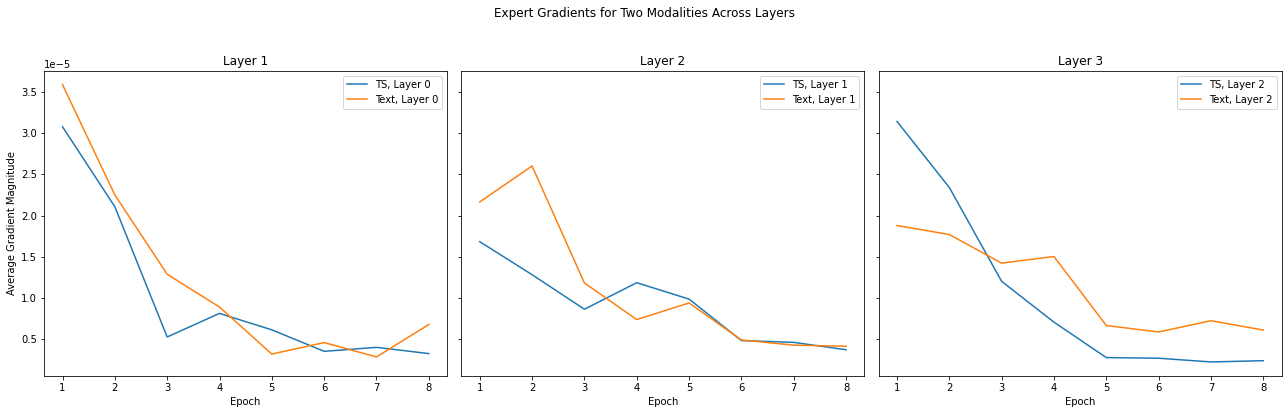

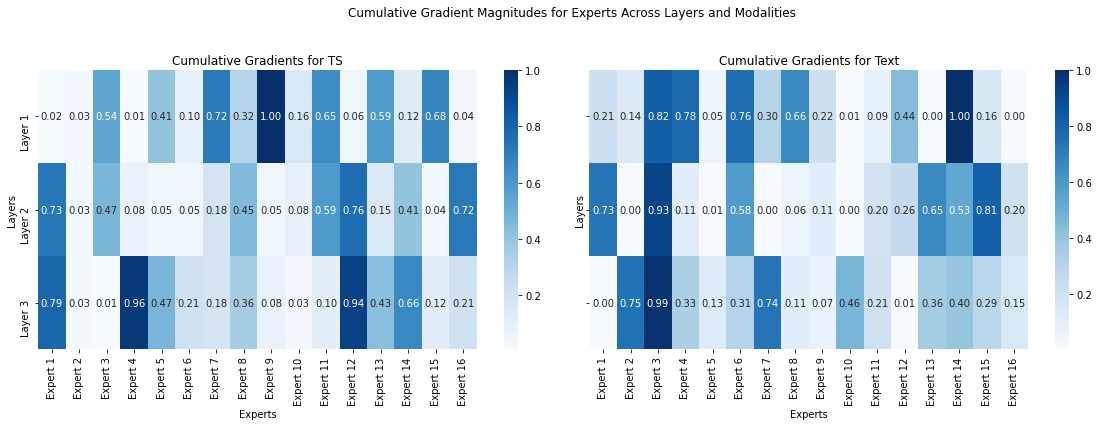

In [18]:
base_path = "/data/wang/junh/results/Fuse_moe/all_los/pid_results_2mod/gradients"
file_name = "TS_Text/S_TS_Text"

S_TS_Text = load_gradients(base_path, file_name)

# Define modalities and labels
modalities = ["w_gate.0", "w_gate.1"]
modality_labels = ["TS", "Text"]

# Calculate and plot expert averages
print("Redundancy between TS and Text")
plot_expert_averages(S_TS_Text, modalities, modality_labels)

# Aggregate and plot cumulative gradients
aggregated_gradients = aggregate_gradients(S_TS_Text, modalities, 3, 16)
plot_cumulative_gradients(aggregated_gradients, modality_labels)

Redundancy between TS and Text


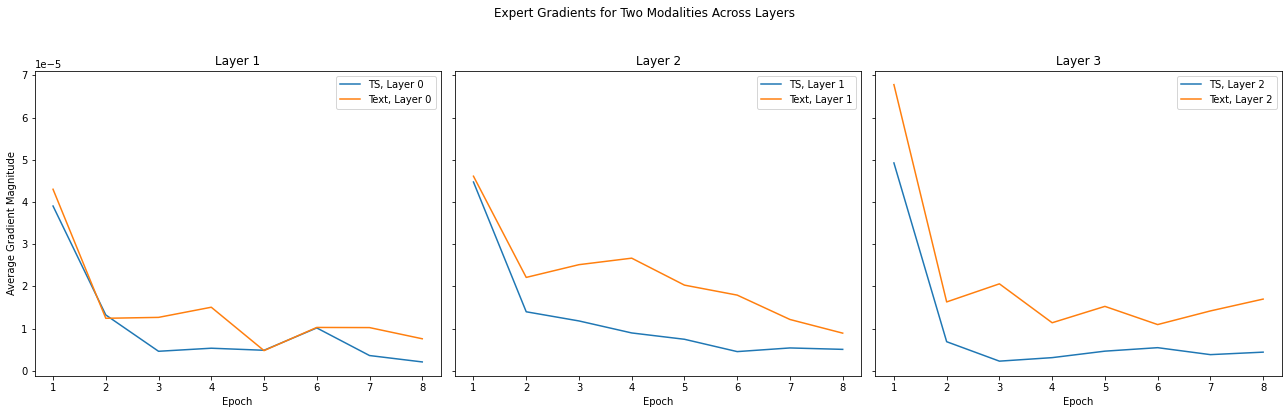

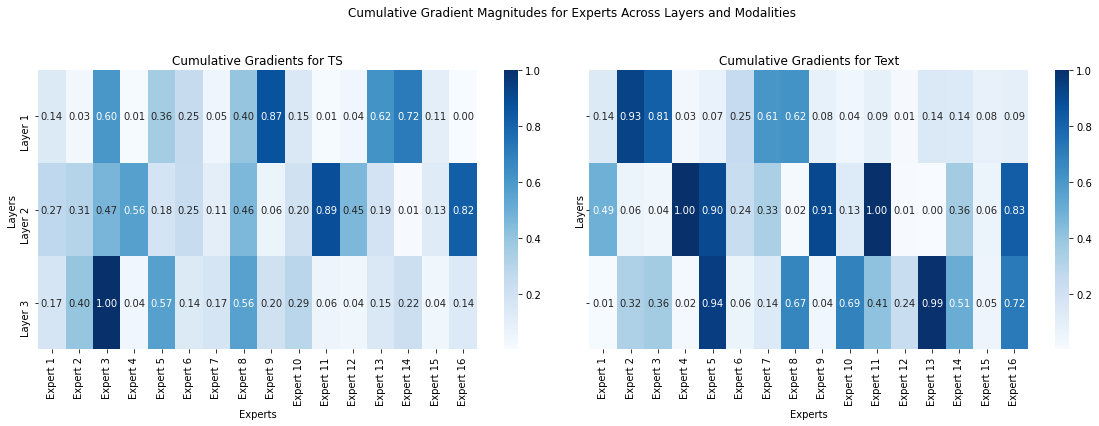

In [8]:
base_path = "/data/wang/junh/results/Fuse_moe/all_los/pid_results_2mod/gradients"
file_name = "TS_Text/U_TS_Text"

U_TS_Text = load_gradients(base_path, file_name)

# Define modalities and labels
modalities = ["w_gate.0", "w_gate.1"]
modality_labels = ["TS", "Text"]

# Calculate and plot expert averages
print("Redundancy between TS and Text")
plot_expert_averages(U_TS_Text, modalities, modality_labels)

# Aggregate and plot cumulative gradients
aggregated_gradients = aggregate_gradients(U_TS_Text, modalities, 3, 16)
plot_cumulative_gradients(aggregated_gradients, modality_labels)